70.単語ベクトルの和による特徴量

In [4]:
# 問題50で構築したデータ
import pandas as pd
from sklearn.model_selection import train_test_split
 
df = pd.read_csv("./NewsAggregatorDataset/newsCorpora.csv", sep="\t", header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

# 情報源（PUBLISHER）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出
df = df[df["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])] # .isin()：DataFrameの条件抽出
# カテゴリ名と記事見出しの列のみ抽出
df = df[["TITLE", "CATEGORY"]]
 
# 学習、検証、評価用データに分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True)
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True)
 
# データをファイルに保存
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)
 
print("【train】")
print(train["CATEGORY"].value_counts(), "\n") # .value_counts()：要素数をカウント
print("【valid】")
print(valid["CATEGORY"].value_counts(), "\n")
print("【test】")
print(test["CATEGORY"].value_counts())

【train】
CATEGORY
b    4536
e    4199
t    1217
m     720
Name: count, dtype: int64 

【valid】
CATEGORY
e    543
b    540
t    156
m     95
Name: count, dtype: int64 

【test】
CATEGORY
b    551
e    537
t    151
m     95
Name: count, dtype: int64


In [5]:
# 学習済み単語ベクトルのロード
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [6]:
import string
import torch

def transform_w2v(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) # 記号をスペースに変換
  words = text.translate(table).split()  # スペースで分割してリスト化
  vec = [model[word] for word in words if word in model]  # 1語ずつベクトル化

  return torch.tensor(sum(vec) / len(vec))  # 平均ベクトルをTensor型に変換して出力

In [7]:
# 特徴ベクトルの作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([10672, 300])
tensor([[ 4.2521e-03,  4.4006e-02, -9.8433e-02,  ..., -7.6803e-03,
         -4.1572e-02,  1.4148e-01],
        [ 1.0022e-01,  2.6396e-02,  2.3794e-02,  ...,  1.0681e-04,
          1.3090e-02, -4.6186e-02],
        [ 5.5176e-02,  7.2893e-03, -2.2330e-01,  ..., -4.3480e-02,
         -4.3143e-02, -7.1934e-02],
        ...,
        [ 7.5100e-02, -1.4313e-02, -8.8867e-02,  ..., -1.1011e-02,
         -7.0679e-02, -4.1144e-02],
        [ 2.0955e-01,  3.6749e-02, -1.2229e-01,  ...,  7.2289e-02,
          5.8929e-02, -4.8645e-02],
        [ 2.3578e-02,  1.5771e-02, -3.1641e-02,  ..., -3.3340e-02,
          3.0435e-02, -1.9507e-02]])


In [8]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([10672])
tensor([3, 2, 2,  ..., 2, 0, 2])


In [9]:
# 保存
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

71.単層ニューラルネットワークによる予測

In [10]:
from torch import nn

class SLPNet(nn.Module): # 単層ニューラルネットワークを定義
  def __init__(self, input_size, output_size): # ネットワークを構成するレイヤーを定義
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x): # 入力データが順伝播時に通るレイヤーを配置
    x = self.fc(x)
    return x

In [11]:
model = SLPNet(300, 4)  # 単層ニューラルネットワークの初期化
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.1313, 0.3593, 0.1002, 0.4092]], grad_fn=<SoftmaxBackward0>)


In [12]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.1313, 0.3593, 0.1002, 0.4092],
        [0.0150, 0.6370, 0.2917, 0.0563],
        [0.0137, 0.0981, 0.8600, 0.0282],
        [0.1956, 0.2105, 0.4710, 0.1229]], grad_fn=<SoftmaxBackward0>)


72.損失と勾配の計算

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
l_1 = criterion(model(X_train[:1]), y_train[:1])
model.zero_grad()  # 勾配をゼロで初期化
l_1.backward()  # 誤差逆伝播により勾配を計算
print(f'損失: {l_1:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.8935
勾配:
tensor([[ 0.0006,  0.0058, -0.0129,  ..., -0.0010, -0.0055,  0.0186],
        [ 0.0015,  0.0158, -0.0354,  ..., -0.0028, -0.0149,  0.0508],
        [ 0.0004,  0.0044, -0.0099,  ..., -0.0008, -0.0042,  0.0142],
        [-0.0025, -0.0260,  0.0582,  ...,  0.0045,  0.0246, -0.0836]])


In [15]:
l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l:.4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 0.7573
勾配:
tensor([[-0.0003, -0.0029, -0.0063,  ..., -0.0003,  0.0007,  0.0032],
        [ 0.0166,  0.0035, -0.0131,  ..., -0.0017, -0.0004,  0.0024],
        [-0.0169,  0.0084,  0.0076,  ...,  0.0011, -0.0077,  0.0171],
        [ 0.0005, -0.0089,  0.0118,  ...,  0.0009,  0.0074, -0.0227]])


73.確率的勾配降下法による学習

In [16]:
from torch.utils.data import Dataset

class NewsDataset(Dataset):
  def __init__(self, X, y):  # datasetの構成要素を指定(特徴ベクトルとラベルベクトル)
    self.X = X
    self.y = y

  def __len__(self):  # len(dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, idx):  # dataset[idx]で返す値を指定
    return [self.X[idx], self.y[idx]]

In [17]:
from torch.utils.data import DataLoader

# Datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderの作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 20
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 損失を記録
    loss_train += loss.item()
 
  # バッチ単位の平均損失計算
  loss_train = loss_train / i

  # 検証データの損失計算
  model.eval() 
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid)) # データローダーから順に取り出す
    outputs = model(inputs) # 予測値を取得
    loss_valid = criterion(outputs, labels) # 損失計算

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

epoch: 1, loss_train: 0.4587, loss_valid: 0.3128
epoch: 2, loss_train: 0.3154, loss_valid: 0.2836
epoch: 3, loss_train: 0.2880, loss_valid: 0.2648
epoch: 4, loss_train: 0.2724, loss_valid: 0.2642
epoch: 5, loss_train: 0.2626, loss_valid: 0.2576
epoch: 6, loss_train: 0.2556, loss_valid: 0.2567
epoch: 7, loss_train: 0.2504, loss_valid: 0.2566
epoch: 8, loss_train: 0.2458, loss_valid: 0.2550
epoch: 9, loss_train: 0.2428, loss_valid: 0.2555
epoch: 10, loss_train: 0.2398, loss_valid: 0.2598
epoch: 11, loss_train: 0.2376, loss_valid: 0.2554
epoch: 12, loss_train: 0.2359, loss_valid: 0.2559
epoch: 13, loss_train: 0.2330, loss_valid: 0.2587
epoch: 14, loss_train: 0.2318, loss_valid: 0.2616
epoch: 15, loss_train: 0.2302, loss_valid: 0.2583
epoch: 16, loss_train: 0.2293, loss_valid: 0.2630
epoch: 17, loss_train: 0.2286, loss_valid: 0.2621
epoch: 18, loss_train: 0.2274, loss_valid: 0.2630
epoch: 19, loss_train: 0.2268, loss_valid: 0.2671
epoch: 20, loss_train: 0.2261, loss_valid: 0.2647


74.正解率の計算

In [20]:
def calculate_accuracy(model, loader):
  model.eval() # モデルを評価モードに設定
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配計算を無効化し、モデルのパラメータが更新されないようにする
    for inputs, labels in loader: # データローダーから、バッチごとにデータとラベルを取得
      outputs = model(inputs) # 入力データの予測値を取得
      pred = torch.argmax(outputs, dim=-1) # 予測値の中でもっとも確率の高いクラスを選択
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [21]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.926
正解率（評価データ）：0.910


75.損失と正解率のプロット

In [22]:
def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval() # 評価モード
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total

In [23]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  # エポックごとに損失、正解率を保存
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3349, accuracy_train: 0.8831, loss_valid: 0.3130, accuracy_valid: 0.8906
epoch: 2, loss_train: 0.2951, accuracy_train: 0.9003, loss_valid: 0.2785, accuracy_valid: 0.9018
epoch: 3, loss_train: 0.2723, accuracy_train: 0.9100, loss_valid: 0.2627, accuracy_valid: 0.9033
epoch: 4, loss_train: 0.2673, accuracy_train: 0.9093, loss_valid: 0.2618, accuracy_valid: 0.9048
epoch: 5, loss_train: 0.2556, accuracy_train: 0.9147, loss_valid: 0.2573, accuracy_valid: 0.9093
epoch: 6, loss_train: 0.2465, accuracy_train: 0.9179, loss_valid: 0.2531, accuracy_valid: 0.9093
epoch: 7, loss_train: 0.2413, accuracy_train: 0.9190, loss_valid: 0.2542, accuracy_valid: 0.9085
epoch: 8, loss_train: 0.2399, accuracy_train: 0.9211, loss_valid: 0.2540, accuracy_valid: 0.9085
epoch: 9, loss_train: 0.2337, accuracy_train: 0.9214, loss_valid: 0.2552, accuracy_valid: 0.9070
epoch: 10, loss_train: 0.2349, accuracy_train: 0.9203, loss_valid: 0.2610, accuracy_valid: 0.9033
epoch: 11, loss_train: 0.2295

In [29]:
from matplotlib import pyplot as plt
import numpy as np

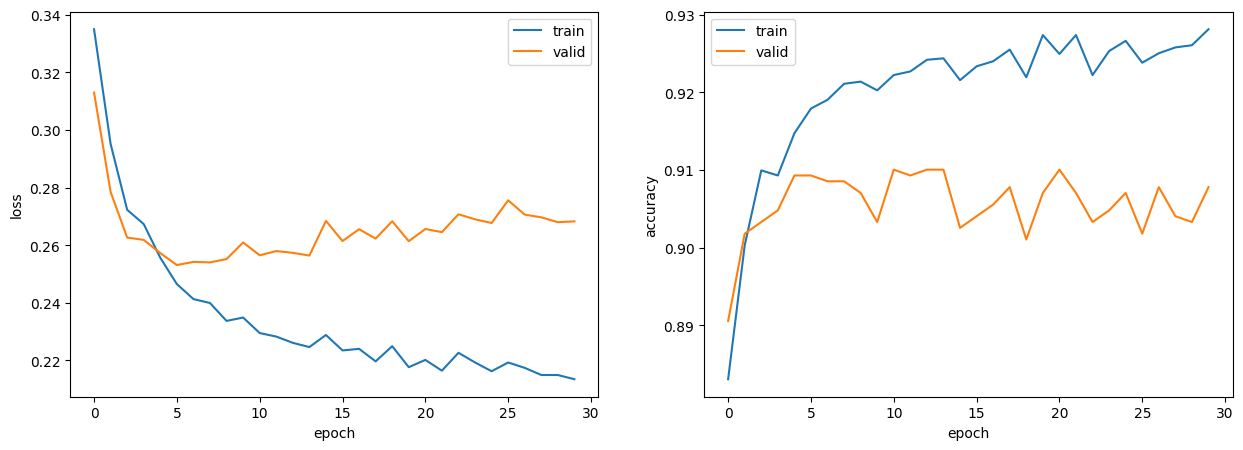

In [30]:
# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

76.チェックポイント

In [32]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in range(num_epochs):
  # 訓練モードに設定
  model.train()
  for inputs, labels in dataloader_train:
    # 勾配をゼロで初期化
    optimizer.zero_grad()

    # 順伝播 + 誤差逆伝播 + 重み更新
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
 
  # 損失と正解率の算出
  loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントの保存
  # model.state_dict()で学習途中のパラメータ、optimizer.state_dict()で最適化アルゴリズムの内部状態にアクセス可能
  torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

  # ログを出力
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')  

epoch: 1, loss_train: 0.3450, accuracy_train: 0.8785, loss_valid: 0.3293, accuracy_valid: 0.8846
epoch: 2, loss_train: 0.2947, accuracy_train: 0.8987, loss_valid: 0.2868, accuracy_valid: 0.8988
epoch: 3, loss_train: 0.2757, accuracy_train: 0.9047, loss_valid: 0.2723, accuracy_valid: 0.9003
epoch: 4, loss_train: 0.2682, accuracy_train: 0.9094, loss_valid: 0.2690, accuracy_valid: 0.9070
epoch: 5, loss_train: 0.2530, accuracy_train: 0.9126, loss_valid: 0.2649, accuracy_valid: 0.9033
epoch: 6, loss_train: 0.2471, accuracy_train: 0.9162, loss_valid: 0.2594, accuracy_valid: 0.9048
epoch: 7, loss_train: 0.2415, accuracy_train: 0.9177, loss_valid: 0.2597, accuracy_valid: 0.9025
epoch: 8, loss_train: 0.2407, accuracy_train: 0.9165, loss_valid: 0.2634, accuracy_valid: 0.9048
epoch: 9, loss_train: 0.2373, accuracy_train: 0.9201, loss_valid: 0.2570, accuracy_valid: 0.9040
epoch: 10, loss_train: 0.2311, accuracy_train: 0.9212, loss_valid: 0.2558, accuracy_valid: 0.9063
epoch: 11, loss_train: 0.2299

77.ミニバッチ化

In [36]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
  
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, time: {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [37]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3400, accuracy_train: 0.8854, loss_valid: 0.3185, accuracy_valid: 0.8921, time: 2.8572sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3096, accuracy_train: 0.8931, loss_valid: 0.2957, accuracy_valid: 0.8936, time: 1.5546sec
バッチサイズ: 4
epoch: 1, loss_train: 0.3010, accuracy_train: 0.8948, loss_valid: 0.2908, accuracy_valid: 0.8951, time: 0.8406sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2954, accuracy_train: 0.8990, loss_valid: 0.2832, accuracy_valid: 0.9003, time: 0.4737sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2935, accuracy_train: 0.8994, loss_valid: 0.2821, accuracy_valid: 0.9003, time: 0.2932sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2925, accuracy_train: 0.8997, loss_valid: 0.2813, accuracy_valid: 0.9018, time: 0.3114sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2921, accuracy_train: 0.8997, loss_valid: 0.2811, accuracy_valid: 0.9025, time: 0.1520sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2919, accuracy_train: 0.8996, loss_valid: 0.2810, accuracy_valid: 0.9025, time: 0.1309sec
バッチ

78.GPU上での学習

In [39]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, time: {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [41]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの学習
for batch_size in [2 ** i for i in range(11)]:
  print(f'バッチサイズ: {batch_size}')
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3366, accuracy_train: 0.8825, loss_valid: 0.3292, accuracy_valid: 0.8853, time: 2.9194sec
バッチサイズ: 2
epoch: 1, loss_train: 0.3059, accuracy_train: 0.8943, loss_valid: 0.3032, accuracy_valid: 0.8928, time: 1.5675sec
バッチサイズ: 4
epoch: 1, loss_train: 0.2970, accuracy_train: 0.8970, loss_valid: 0.2951, accuracy_valid: 0.8981, time: 0.8479sec
バッチサイズ: 8
epoch: 1, loss_train: 0.2927, accuracy_train: 0.9006, loss_valid: 0.2910, accuracy_valid: 0.9003, time: 0.4833sec
バッチサイズ: 16
epoch: 1, loss_train: 0.2907, accuracy_train: 0.9014, loss_valid: 0.2902, accuracy_valid: 0.9003, time: 0.2938sec
バッチサイズ: 32
epoch: 1, loss_train: 0.2902, accuracy_train: 0.9017, loss_valid: 0.2894, accuracy_valid: 0.8988, time: 0.1986sec
バッチサイズ: 64
epoch: 1, loss_train: 0.2895, accuracy_train: 0.9017, loss_valid: 0.2890, accuracy_valid: 0.9003, time: 0.1527sec
バッチサイズ: 128
epoch: 1, loss_train: 0.2896, accuracy_train: 0.9017, loss_valid: 0.2889, accuracy_valid: 0.9003, time: 0.1299sec
バッチ

79.多層ニューラルネットワーク

In [42]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))
 
    return x

In [43]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return loss / len(loader), correct / total
  

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [44]:
# datasetの作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device)

epoch: 1, loss_train: 1.0296, accuracy_train: 0.7152, loss_valid: 1.0272, accuracy_valid: 0.7166, 3.0192sec
epoch: 2, loss_train: 0.7498, accuracy_train: 0.7659, loss_valid: 0.7555, accuracy_valid: 0.7624, 0.6326sec
epoch: 3, loss_train: 0.6646, accuracy_train: 0.7746, loss_valid: 0.6729, accuracy_valid: 0.7699, 0.6316sec
epoch: 4, loss_train: 0.6265, accuracy_train: 0.7808, loss_valid: 0.6350, accuracy_valid: 0.7766, 0.6369sec
epoch: 5, loss_train: 0.5984, accuracy_train: 0.7828, loss_valid: 0.6066, accuracy_valid: 0.7789, 0.6411sec
epoch: 6, loss_train: 0.5720, accuracy_train: 0.7871, loss_valid: 0.5794, accuracy_valid: 0.7834, 0.6120sec
epoch: 7, loss_train: 0.5507, accuracy_train: 0.7941, loss_valid: 0.5582, accuracy_valid: 0.7901, 0.6261sec
epoch: 8, loss_train: 0.5239, accuracy_train: 0.8098, loss_valid: 0.5307, accuracy_valid: 0.8028, 0.6187sec
epoch: 9, loss_train: 0.5034, accuracy_train: 0.8177, loss_valid: 0.5092, accuracy_valid: 0.8103, 0.6184sec
epoch: 10, loss_train: 0.484

In [45]:
def calculate_accuracy(model, loader, device):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
      
  return correct / total

In [46]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train, device)
acc_test = calculate_accuracy(model, dataloader_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.930
正解率（評価データ）：0.918
